This notebook serves as a showcase for the functions written in the DataAnalysis package, more specifically the OnlineSensorBased subclass.

# Loading packages

In [1]:
import sys
import os
from os import listdir
import pandas as pd
import scipy as sp
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt   
%matplotlib inline

import wwdata as ww

LabExperimBased imported
LabSensorBased imported
OnlineSensorBased imported


# Reading data

In [2]:
measurements = pd.read_csv('./data/201301.txt',sep='\t',skiprows=0)
measurements.columns

Index([u'Time', u'TSS_line3', u'NO3_line3', u'CODtot_line3', u'CODsol_line3',
       u'TSS_line2', u'NO3_line2', u'CODtot_line2', u'CODsol_line2',
       u'TSS_line1', u'NO3_line1', u'CODtot_line1', u'CODsol_line1',
       u'Cond_ns', u'Turb_ns', u'Temp_ns', u'Ammonium_ns', u'Cond_es',
       u'Turb_es', u'Temp_es', u'NH4_infl', u'NH3_line3', u'Turb_rz',
       u'Cond_rz', u'Temp_rz', u'PO4_mixinggutter', u'TSS_efflPST',
       u'NO3_efflPST', u'CODtot_efflPST', u'CODsol_efflPST', u'TSS_efflRBT',
       u'NO3_efflRBT', u'CODtot_efflRBT', u'CODsol_efflRBT', u'Cond_line1',
       u'Turb_line1', u'Cond_line2', u'Turb_line2', u'Cond_line3',
       u'Turb_line3', u'NH4_efflPST', u'PO4_efflPST', u'PO4_sandtrap',
       u'NH4_splittingworks', u'PO4_splittingworks', u'Flow_line1',
       u'Flow_line2', u'Flow_line3', u'Flow_total'],
      dtype='object')

# Create Class object and format data

In [3]:
dataset = ww.OnlineSensorBased(data=measurements,
                               timedata_column='Time',
                               data_type='WWTP')
dataset.set_tag('January 2013')
dataset.replace('Bad','NaN',inplace=True)

Convert the values in the column containing time data to the pandas datetime format.

In [4]:
dataset.to_datetime(time_column=dataset.timename,time_format='%d-%m-%y %H:%M')

use the time-column as index

In [5]:
dataset.time_to_index(drop=True,inplace=True)

Convert the absolute timestamps to relative values. This can be important when data is to be used for modeling purposes later on, and needs to be written to text files.

In [6]:
#dataset.absolute_to_relative(time_data='index',unit='d')

Drop any indexes that might be present in the index

In [7]:
dataset.drop_index_duplicates()

Convert all or the selected columns to float type.

In [8]:
dataset.to_float(columns='all')

# Select data

Selecting data happens through tagging, so no original data is lost. When applying filter algorithms such as tag_doubles, moving_slope_filter etc., a new pandas dataframe is created (dataset.meta_valid) that contains these tags. It is also based on this new dataframe that the plotting of selected and not selected datapoints in different colours happens.

The written output of the filter functions tells the user how many data points were tagged based on that specific function. When the plotting argument is set to true, the plot shows the aggregated results of the filter functions used up until that point.

Plot an example data column before start of the selection procedure

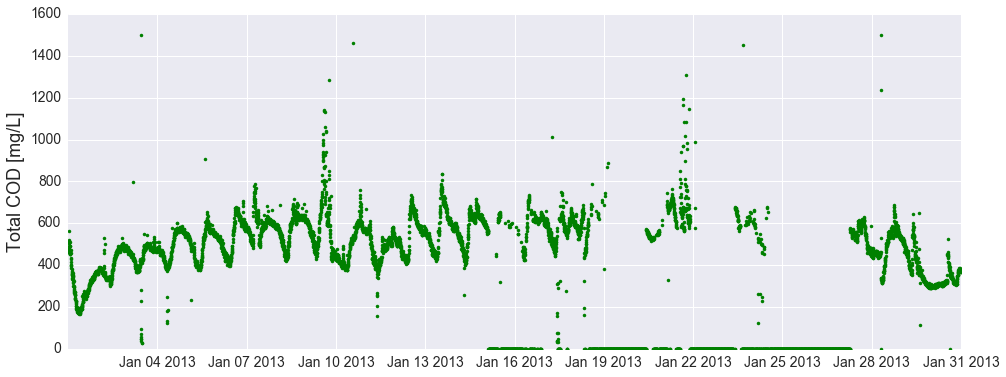

In [38]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(dataset.data['CODtot_line2'],'.g')
ax.set_ylabel('Total COD [mg/L]',fontsize=18);ax.set_xlabel('')
ax.tick_params(labelsize=14)

## Maxima
Tag the data points that are higher then a certain percentile

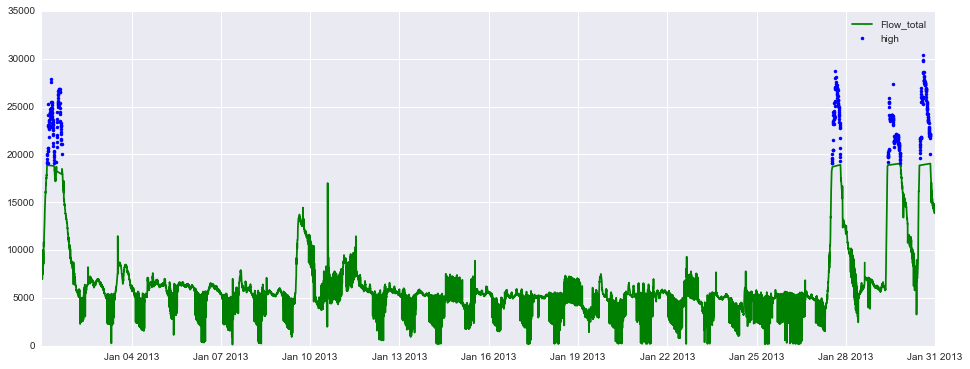

In [10]:
dataset.get_highs('Flow_total',0.95,method='percentile',plot=True)

## NaN values
Tag all NaN (Not a Number) values as 'filtered'.

In [11]:
dataset.tag_nan('CODtot_line2')

47 NaN values detected and tagged as filtered.


## Sensor failure
Tag all datapoints that are part of a constant (within a given bound) signal.

In [14]:
dataset.tag_doubles('CODtot_line2',bound=0.05,plot=False)

Original dataset: 8593 datapoints
New dataset: 6123 datapoints
2470 datapoints  filtered


70.8680555556% datapoints are left over from the original 8640.0


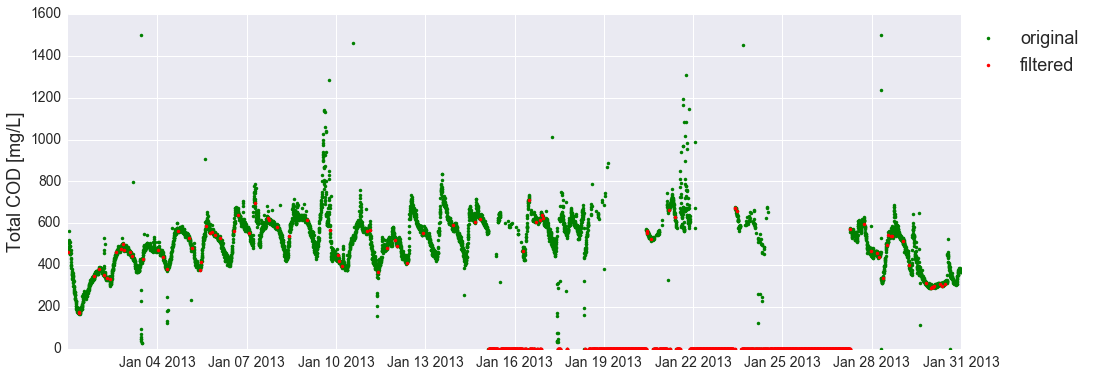

In [29]:
fig, ax = dataset.plot_analysed('CODtot_line2')
ax.legend(bbox_to_anchor=(1.15,1.0),fontsize=18)
ax.set_ylabel('Total COD [mg/L]',fontsize=18);ax.set_xlabel('')
ax.tick_params(labelsize=14)

## Noise 
Tag all data points for which the slope as compared with the previous point is too high to be realistic (i.e. the data point is noisy).

Original dataset: 8593 datapoints
New dataset: 8394 datapoints
199 datapoints  filtered
68.5648148148% datapoints are left over from the original 8640.0


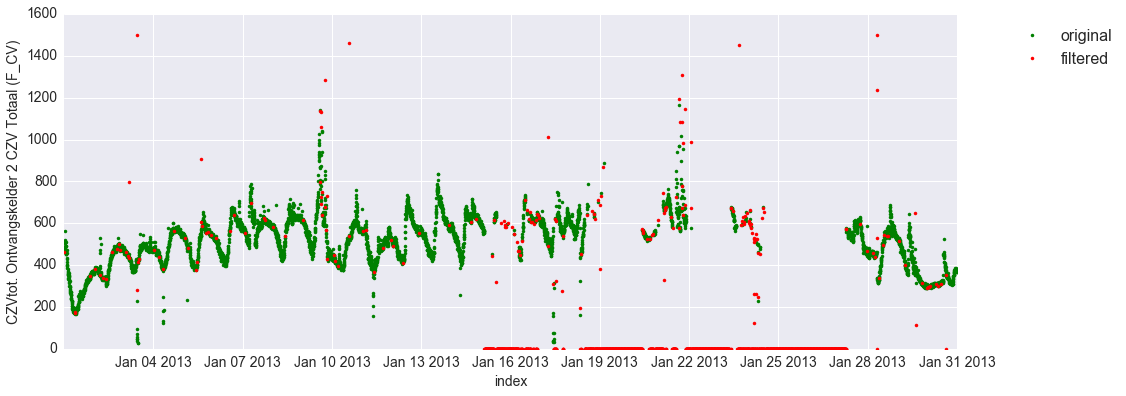

In [12]:
dataset.moving_slope_filter('index','CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                            72000,time_unit='d',inplace=False,plot=True)

Tag all data points that are more than a specified percentage away from the calculated moving average. This function makes use of the simple_moving_average function, also written as part of this package.

Original dataset: 8593 datapoints
New dataset: 6067 datapoints
2526 datapoints  filtered
67.8703703704% datapoints are left over from the original 8640.0


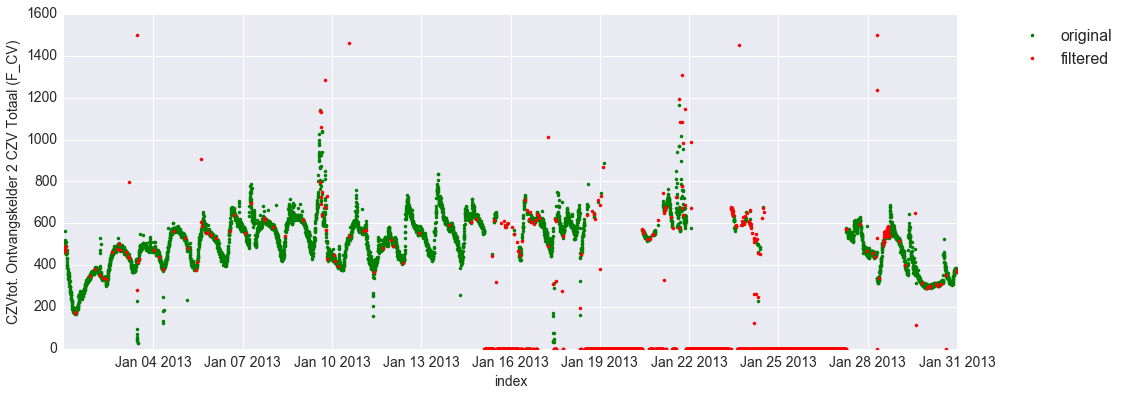

In [14]:
dataset.moving_average_filter(data_name='CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                              window=12,cutoff_perc=20,plot=True)

In [13]:
#dataset.savgol('TSS_prop')

# Fill data

Filling data can be done using a range of functions implemented in the package. Again, a new pandas dataframe is created (dataset.meta_filled), starting from the dataset.meta_valid dataframe, and updated with tags indicating what filling method was used to obtain a certain point.

Using the falsified_only argument, the user can always choose whether only data points tagged as 'filtered' will be used, or all data points within a certain range.

When using the plotting argument to plot the analysed data, the user will see a plot based on the latest function that was used; if this was a filter function, the data will be plotted based on the dataset.meta_valid dataframe, if it was a filling function, the tags in dataset.meta_filled will be used.

## Interpolation
Fill missing data points by interpolation, if number of consecutive missing points is lower than a specified number.

hydropy/Class_OnlineSensorBased.py:241: UserWarning: When making use of filling functions, please make sure to         start filling small gaps and progressively move to larger gaps. This         ensures the proper working of the package algorithms.
  ensures the proper working of the package algorithms.')
hydropy/Class_OnlineSensorBased.py:284: UserWarning: Data points obtained during a rain event will be replaced.             Make sure you are confident in this replacement method for the             filling of gaps in the data during rain events.
  filling of gaps in the data during rain events.')


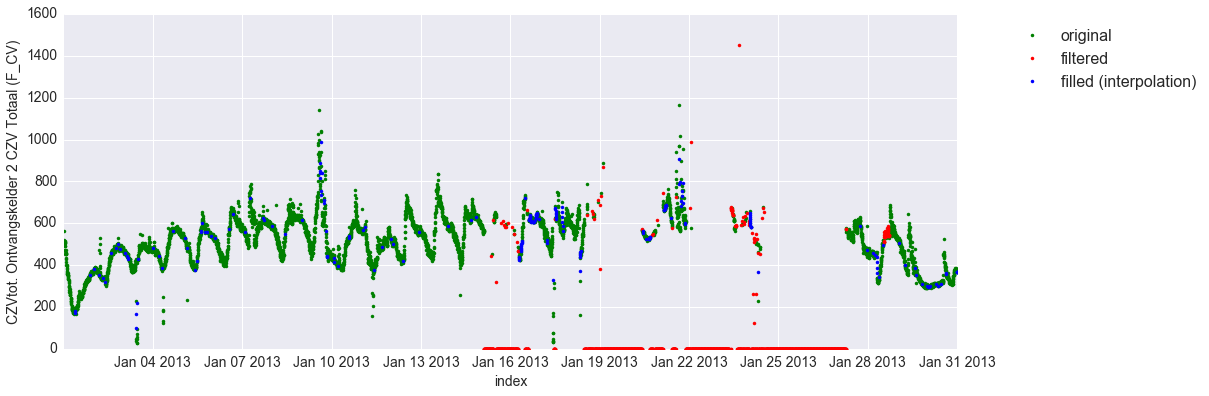

In [15]:
dataset.fill_missing_interpolation('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                                   12,[dt.datetime(2013,1,1),dt.datetime(2013,1,31)],
                                   plot=True)

## Average daily profile
Fill missing datapoints by using an average daily profile. The fill_missing_standard function requires the running of the calc_daily_profile function, also developed for this package, first. This creates a dataframe (dataset.daily_profile) containing the average daily profile calculated within a defined time period (e.g. selecting only non-peak days for example).

In [16]:
dataset.calc_daily_profile('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                           [dt.datetime(2013,1,1),dt.datetime(2013,1,8)],
                           quantile=0.9,clear=True)

hydropy/Class_HydroData.py:1336: UserWarning: Data points obtained during a rain event will be used for the calculation of an average day. This might lead to a not-representative average day and/or high standard deviations.
  'representative average day and/or high standard deviations.')


hydropy/Class_OnlineSensorBased.py:585: UserWarning: When making use of filling functions, please make sure to         start filling small gaps and progressively move to larger gaps. This         ensures the proper working of the package algorithms.
  ensures the proper working of the package algorithms.')


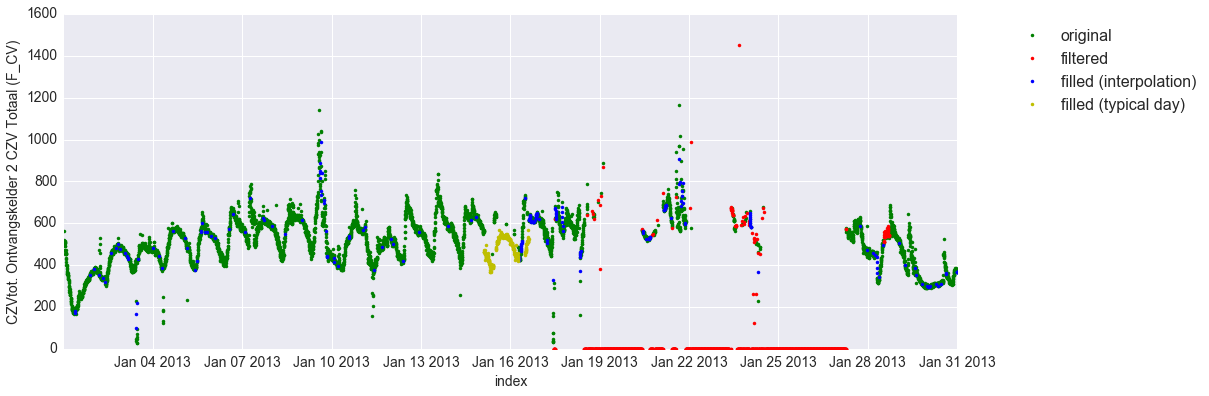

In [17]:
dataset.fill_missing_standard('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                              [dt.datetime(2013,1,14),dt.datetime(2013,1,17)],
                              filtered_only=True,clear=False,plot=True)

## Model output
Fill gaps using a model output. This assumes that the user has good reason to trust that the model predictions are sound and can indeed be used to replace missing data where needed.

In [18]:
model_output_ontv_1 = pd.read_csv('./data/Model_InfluentModelCalibration_WEST_ontv_1.txt',
                           sep='\t')
units_model = model_output_ontv_1.ix[0]
model_output_ontv_1 = model_output_ontv_1.drop(0,inplace=False).reset_index(drop=True)
model_output_ontv_1 = model_output_ontv_1.astype(float)
model_output_ontv_1.set_index('#.t',drop=True,inplace=True)
model_output_ontv_1.columns

/Users/chaimdemulder/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'.sewer_1.COD', u'.sewer_1.CODs', u'.sewer_1.NH4', u'.sewer_1.PO4',
       u'.sewer_1.Q_DWF_UB', u'.sewer_1.Q_in', u'.sewer_1.TSS'],
      dtype='object')

hydropy/Class_OnlineSensorBased.py:721: UserWarning: When making use of filling functions, please make sure to         start filling small gaps and progressively move to larger gaps. This         ensures the proper working of the package algorithms.
  ensures the proper working of the package algorithms.')


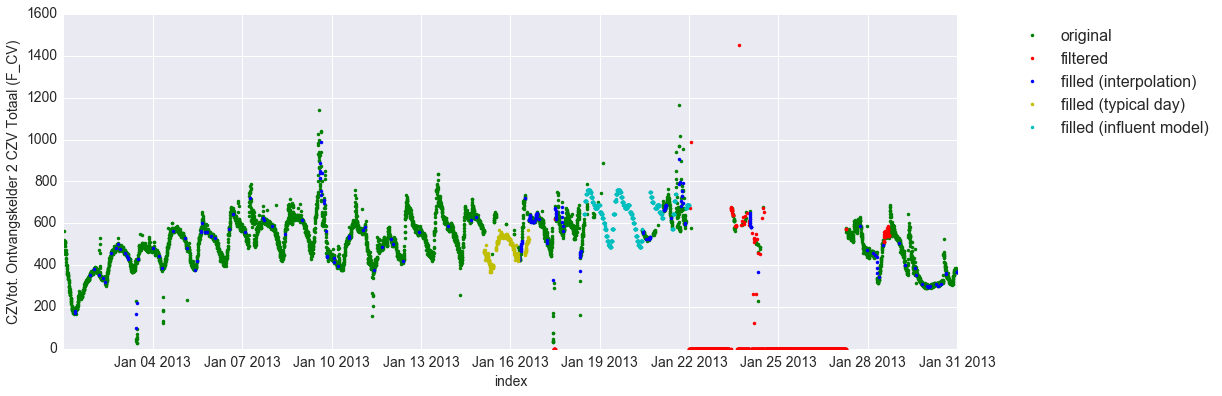

In [19]:
dataset.fill_missing_model('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                           model_output_ontv_1['.sewer_1.COD'],
                           [dt.datetime(2013,1,18),dt.datetime(2013,1,22)],
                           filtered_only=True,plot=True)

## Ratio or correlation
Constant ratios or correlations between data can be used to filled missing points. The user can calculate and compare ratios and correlations (currently only linear) between selected measurements, and fill data using these.

*nb: in the examples below, data filling based on ratios or correlation is obviously not a very good choice. Both methods are included here for completeness of method showcasing.*

In [20]:
dataset.calc_ratio('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                   'CZVnf. Ontvangskelder 2  CZV Opgelost (F_CV)',
                   [dt.datetime(2013,1,1,0,5,0),dt.datetime(2013,1,31)])

(2.450642327196896, 0.672153214085126)

In [21]:
avg,std = dataset.compare_ratio('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                                'CZVnf. Ontvangskelder 2  CZV Opgelost (F_CV)',
                                2)

Best ratio (2.53282188261 ± 0.165864918725) was found in the range: [Timestamp('2013-01-19 00:05:00') Timestamp('2013-01-21 00:05:00')]


hydropy/Class_OnlineSensorBased.py:365: UserWarning: When making use of filling functions, please make sure to         start filling small gaps and progressively move to larger gaps. This         ensures the proper working of the package algorithms.
  ensures the proper working of the package algorithms.')


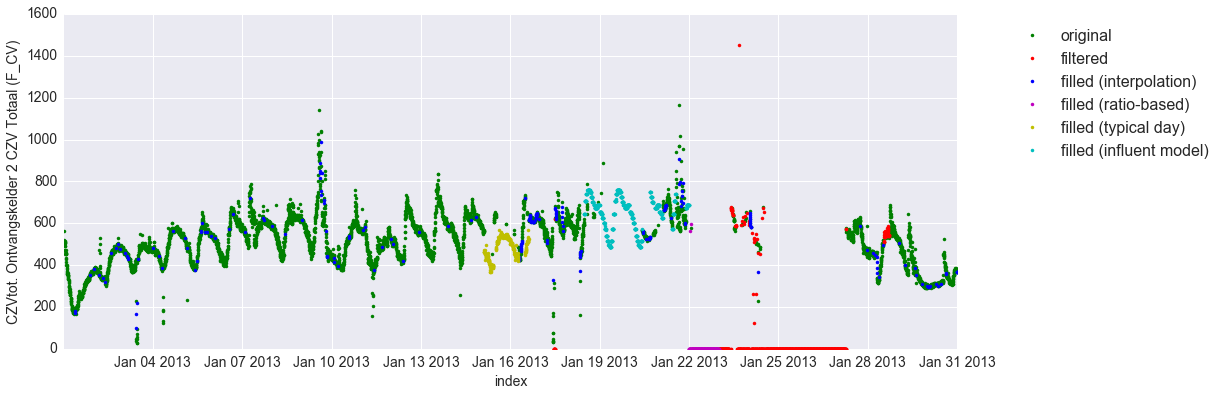

In [22]:
dataset.fill_missing_ratio('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                           'CZVnf. Ontvangskelder 2  CZV Opgelost (F_CV)',avg,
                           [dt.datetime(2013,1,22),dt.datetime(2013,1,23)],
                           filtered_only=True,plot=True)

(2.4013406142627973, 0, 0.97377465637633953)

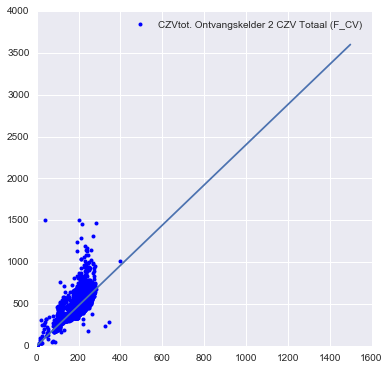

In [23]:
dataset.get_correlation('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                        'CZVnf. Ontvangskelder 2  CZV Opgelost (F_CV)',
                        [dt.datetime(2013,1,1,0,5,0),dt.datetime(2013,1,31)],
                        zero_intercept=True,plot=True)

hydropy/Class_OnlineSensorBased.py:472: UserWarning: When making use of filling functions, please make sure to start filling small gaps and progressively move to larger gaps. This ensures the proper working of the package algorithms.
  'ensures the proper working of the package algorithms.')


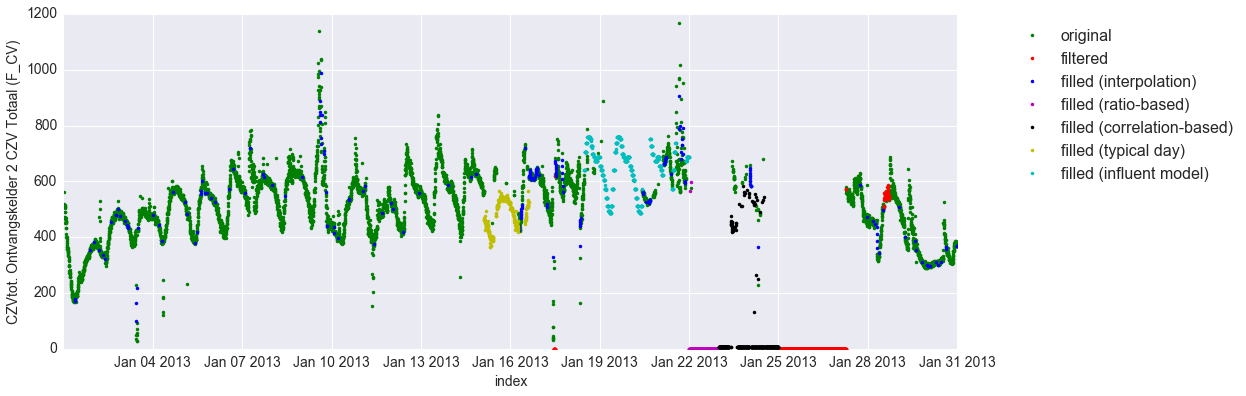

In [24]:
dataset.fill_missing_correlation('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                                 'CZVnf. Ontvangskelder 2  CZV Opgelost (F_CV)',
                                 [dt.datetime(2013,1,23),dt.datetime(2013,1,25)],
                                 [dt.datetime(2013,1,1,0,5,0),dt.datetime(2013,1,31)],
                                 filtered_only=True,clear=False,plot=True)

## Data from previous day
Under the assumption that "The best prediction for tomorrows weather is todays weather", one can also replace missing data by making use of (one of) the previous days.

hydropy/Class_OnlineSensorBased.py:859: UserWarning: When making use of filling functions, please make sure to         start filling small gaps and progressively move to larger gaps. This         ensures the proper working of the package algorithms.
  ensures the proper working of the package algorithms.')


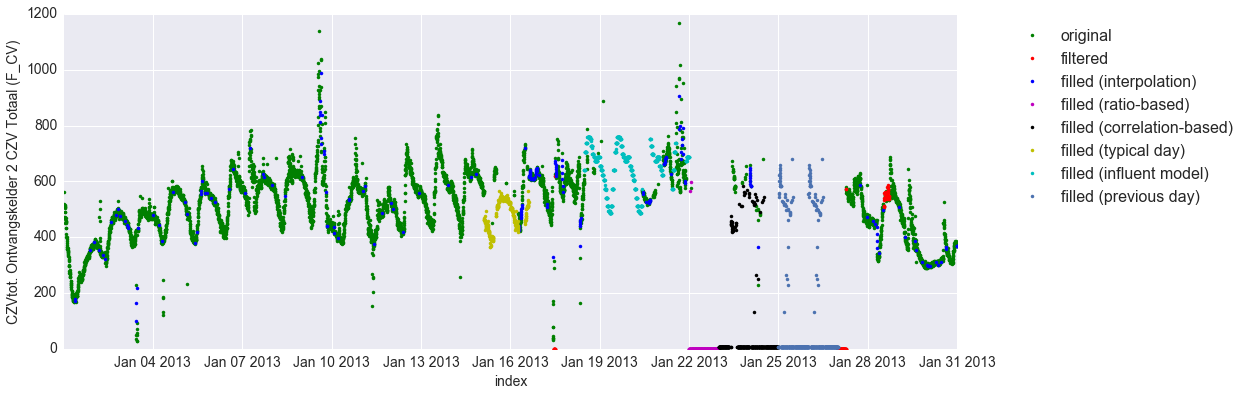

In [25]:
dataset.fill_missing_daybefore('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',
                               [dt.datetime(2013,1,25),dt.datetime(2013,1,27)],
                               range_to_replace=[0,5],plot=True,
                               filtered_only=False)

# Calculations

Calculate the daily average of a certain data series

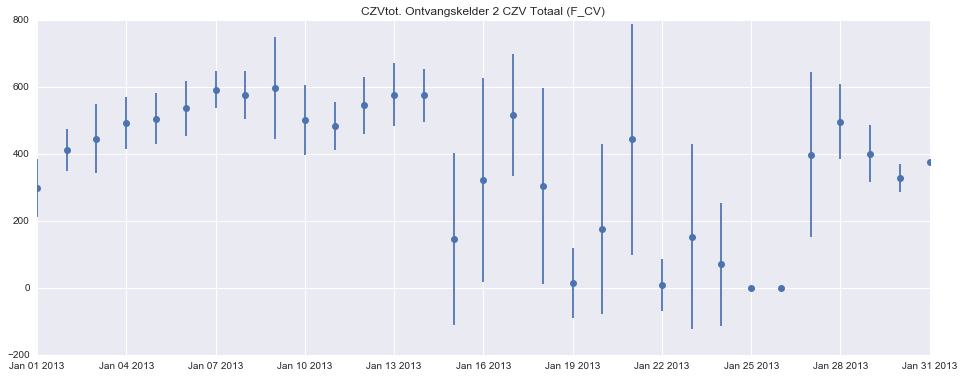

In [27]:
averages = dataset.calc_daily_average('CZVtot. Ontvangskelder 2 CZV Totaal (F_CV)',plot=True)

Calculate the proportional concentration of different flows coming together.

In [28]:
dataset.calc_total_proportional('Totaal debiet influent. waarde T.B.V BBS (F_CV)',
                                ['Debiet ontvangkelder 1. waarde T.B.V BBS (F_CV)',
                                 'Debiet ontvangkelder 2. waarde T.B.V BBS (F_CV)',
                                 'Debiet ontvangkelder 3. waarde T.B.V BBS (F_CV)'],
                                ['TSS. Ontvangskelder 1 Zwevendestof (F_CV)',
                                 'TSS. Ontvangskelder 2  Zwevendestof (F_CV)',
                                 'TSS. Ontvangskelder 3 zwevendestof (F_CV)'],
                               'TSS_prop')

AttributeError: OnlineSensorBased instance has no attribute 'units'

In [ ]:
#dataset.write_to_WEST('test.txt','test_WEST.txt',units)